# Evolutionary Computing: Notebook assignment - Traveling Salesman Problem

This notebook will implement some parts of the lectures slides that are based on Chapter 1 - 4.


# Goal:

You have to run a correct Evolutionary Algorithm, where you will solve the famous Traveling Salesman Problem. You have solved the assignment if the distance travelled is below **13.500 km traveled**.

There are two remarks:
(1) The population size must be <= 100. (2) Number of iterations <=1.000. You are free to change the hyperparameters like probability of mutation / crossover (explanation will follow).

Try to see if your algorithm is able to find such a solution after the amount of generations (iterations) that is given.

Throughout the notebook we have implemented some assert checks, you can use them to make sure your implementation is on the right track.

**Deadline**: **Submit the filled in jupyter notebook through Canvas before September 12, 23:59. Make sure you submit it with the output from the last cell where your solution is visable.**

You will receive a pass/fail grade.

During the practical sessions the TA's will present a presentation with tips & tricks. Please visit Canvas for the room details.

Good luck and have fun!



---




**Rules:**

  * Plagiarism is automatically checked and set to **fail**

  * It is allowed to learn from external resources but copying is not allowed. If you use any external resource, please cite them in the comments (e.g. `# source: https://...../` (see `fitness_function`))

As always, we need to first import several packages:

In [17]:
import numpy as np
from numpy.random import randint
from numpy.random import rand
import random
import matplotlib.pyplot as plt
from typing import List, Tuple

np.random.seed(5)

**Instructions:**

In the notebook, you will see a couple of ToDos with some instructions. Try your best to work through them and to complete the notebook. In case you run into problems, do not hesitate to ask questions on the Canvas Discussion board or during the practicals. You can also check out the other notebook example (one max problem) on Canvas for inspiration.

## Traveler's salesman problem

In this notebook, we will see how we can use EA to solve the famous traveling salesmen problem. In this problem, a salesman person is encountered with the task to visit all cities in the shortest way and returne home. Also, we will assume that the traveler salesman has a fixed starting and end point (Amsterdan). Hence, there are two constraints:

- Each city needs to be visited.
- The traveler needs to start and end home (Amsterdam).

For sake of simplicity, let's assume that we want to find the shortest route for 1 cities in Europe. In particular, we will use the following cities, with the following encoding:

- 0: Amsterdam
- 1: Athens
- 2: Berlin
- 3: Brussels
- 4: Copenhagen
- 5: Edinburgh
- 6: Lisbon
- 7: London
- 8: Madrid
- 9: Paris

if you want to have a example video, please view: https://www.youtube.com/watch?v=1pmBjIZ20pE&ab_channel=AlphaOpt

One way to represent the distances between the cities is to use a so-called adjancey matrix, where $A_{ij}$ denotes the distance from city $i$ to city $j$. The driving distances for the above-mentioned cities  (in km) can be found can be found [here](https://www.engineeringtoolbox.com/driving-distances-d_1029.html). Given this, we can initialize the adjacency matrix:

In [18]:
adjacency_mat = np.asarray(
    #Remember that we use the encoding above, i.e. 0 refers to Amsterdam and 10 to Paris!
    [
        [0, 3082, 649, 209, 904, 1180, 2300, 494, 1782, 515], # Distance Amsterdam to the other cities
        [3082, 0, 2552, 3021, 3414, 3768, 4578, 3099, 3940, 3140], # Distance Athens to the other cities
        [649, 2552, 0, 782, 743, 1727, 3165, 1059, 2527, 1094], # Distance Berlin to the other cities
        [209, 3021, 782, 0, 1035, 996, 2080, 328, 1562, 294], # Distance Brussels to the other cities
        [904, 3414, 743, 1035, 0, 1864, 3115, 1196, 2597, 1329], # Distance Copenhagen to the other cities
        [1180, 3768, 1727, 996, 1864, 0, 2879, 656, 2372, 1082], # Distance Edinburgh to the other cities
        [2300, 4578, 3165, 2080, 3115, 2879, 0, 2210, 638, 1786], # Distance Lisbon to the other cities
        [494, 3099, 1059, 328, 1196, 656, 2210, 0, 1704, 414], # Distance London to the other cities
        [1782, 3940, 2527, 1562, 2597, 2372, 638, 1704, 0, 1268], # Distance Madrid to the other cities
        [515, 3140, 1094, 294, 1329, 1082, 1786, 414, 1268, 0] # Distance Paris to the other cities
    ]

)

An important property of the adjacency matrix is that it is symmetric, hence we will check this first:

In [19]:
(adjacency_mat==adjacency_mat.T).all()

True

For solving this problem, we will need the following key concepts:

- Fitness function
- Variation operators (recombination and mutation)
- Selection operator

For the fitness function, it is intuitiv to take the total number of kilometers traveled as a measure of fitness. The lower the total number of kilometers covered for a given route, the better.

In [20]:
def compute_distance(route: list, adjacency_mat: np.ndarray) -> int:
    '''
    Calculates the total number of kilometers for a given route.
    '''
    total_distance = 0

    if sorted(route) == [0,0,1,2,3,4,5,6,7,8,9]:
        for i in range(len(route) - 1):
            total_distance += adjacency_mat[route[i]][route[i + 1]]
        total_distance += adjacency_mat[route[-1]][route[0]]
        return total_distance
    else:
        raise ValueError("Invalid Route")



In [21]:
def fittest_solution_TSP(compute_distance, generation: list, adjancency_mat: np.ndarray) -> tuple:
    '''
    This function calculates the fitness values of all individuals of a generation.
    It then returns the best fitness value (integer) and the corresponding individual (list).
    '''

    #list contains all the values fitness values
    #there is also an array of all of these lists which represent all the solutions coming from the different inputs.
    #I need to retrieve the best fitness value using compute distance and the corresponding list

    shortest_distance = 999999999
    best_individual = None
    for individual in generation:

        distance = compute_distance(individual, adjancency_mat)
        if distance < shortest_distance:
            shortest_distance = distance
            best_individual = individual
    return shortest_distance, best_individual




Having defined the fitness function, we need of course a function to initialize our generation of solutions.

In [22]:
def initialize_population(n_population: int) -> list:
    '''This returns a randomly initialized list of individual solutions of size n_population.'''

    population = []
    for i in range(n_population):
        cities = list(range(1, 10))
        random.shuffle(cities)
        cities = [0] + cities + [0]
        population.append(cities)



    for individual in population:
        # Implement some assertion tests for checking if the individual meets criteria
        assert (individual[0] == individual[-1] == 0), 'Make sure you start and end in Amsterdam'
        assert len(
            set(individual)) == 10, "Individual must contain all unique values from 0 to 9, as is must visit all cities"
        assert (len(individual) == 11), "Individual must be length 11"

    return population

###Visualizing Solutions

If it comes in handy, you can use this function to visualize your candidate solutions - and make sure they are of correct format. Try the cell block below for an example. Note, you should not adjust this code.

In [23]:
import networkx as nx

def visualize(candidate_solution: list):
    """
    Visualizes the solution to the TSP problem
    """

    #Make sure the candidate solution is valid before trying to visualize it

    assert (candidate_solution[0] == candidate_solution[-1] and candidate_solution[0] == 0 ), 'Make sure you start and end in Amsterdam'
    assert len(set(candidate_solution)) == 10, "Individual must contain all unique values from 0 to 9, as is must visit all cities"
    assert (len(candidate_solution) == 11), "Individual must be length 11"


    edges = [(candidate_solution[i], candidate_solution[i+1]) for i in range(len(candidate_solution) - 1)]

    labels = {
    0: 'Amsterdam',
    1: 'Athens',
    2: 'Berlin',
    3: 'Brussels',
    4: 'Copenhagen',
    5: 'Edinburgh',
    6: 'Lisbon',
    7: 'London',
    8: 'Madrid',
    9: 'Paris'}

    positions = {
    0: (-42.0, 62.0),  # Amsterdam
    1: (10.0, 10),  # Athens
    2: (-5.0, 62.0),    # Berlin
    3: (-45.0, 48.0),  # Brussels
    4: (-30.0, 70.0),   # Copenhagen
    5: (-38.0, 92.0),  # Edinburgh
    6: (-60.0, 15.0),  # Lisbon
    7: (-52.0, 70.0),  # London
    8: (-50.0, 20.0),  # Madrid
    9: (-35.0, 45.0)   # Paris
}

    G = nx.DiGraph()
    G.add_edges_from(edges)

    plt.figure(figsize=(8, 6))
    nx.draw(G, positions, labels=labels, with_labels=True, node_color='lightblue',
            node_size=800, font_size=10, font_weight='bold',
            edge_color='gray', arrowsize=20, arrowstyle='->')


    distance = compute_distance(candidate_solution, adjacency_mat)
    plt.title("TSP Solution\nTotal Distance: " + str (distance))
    plt.show()

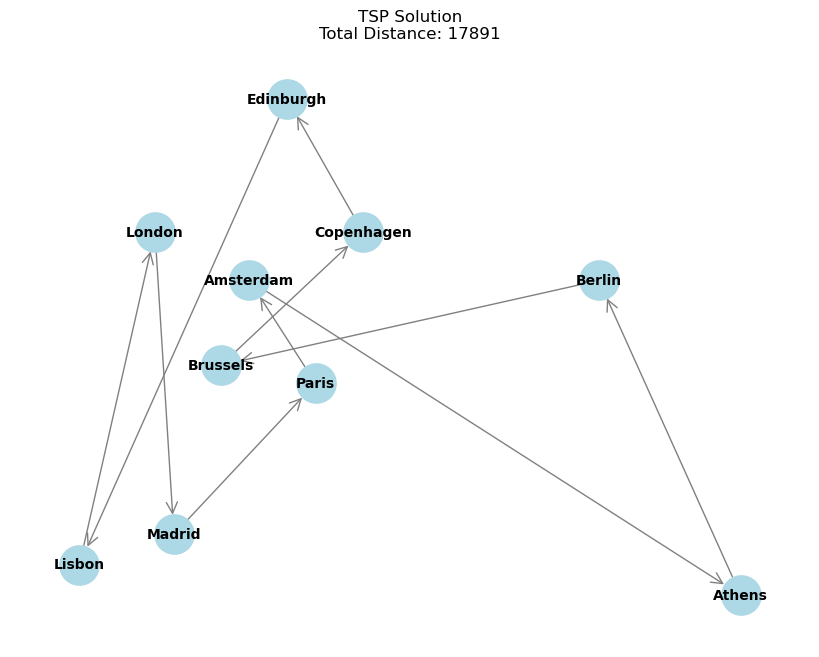

In [24]:
example_solution = [0,1,2,3,4,5,6,7,8,9,0]
visualize(example_solution)

Given that we defined the fitness function and the initialization of the algorithm, we need to define the variational operators, i.e. crossover and mutation. To recall, for permutation problems, one can distinguish problems for which the order is important (production problems) or which elements occur next to each other (adjacency). In our TSP problem, it is important which element occur next to each other, i.e. adjacency.


### Mutation operator:


Regarding the mutation operator, below we will give you some options for inspiration. We can choose from several mutation operators:

- Swap operator
- Insert operator
- Scramble operator
- Inversion operator



Make sure the mutated individual still starts and ends in Amsterdam!

p_mutation is a hyperparameter, dictating the probability of mutation happening to any individual.

In [25]:
def mutation(child:list, p_mutation:float) -> list:
    '''This applies a mutation operator to a list and returns the mutated list.'''

    if np.random.uniform() > p_mutation:
        #no mutation
        return child
    else:
        middle_part = child[1:-1]
        random.shuffle(middle_part)
        child_mutated = [0] + middle_part + [0]

        # Implement some assertion tests for checking if the mutation goes as expected
        assert (child_mutated[0] == child_mutated[-1] and child_mutated[
            0] == 0), 'Make sure you start and end in Amsterdam'
        assert len(
            set(child_mutated)) == 10, "Individual must contain all unique values from 0 to 9, as is must visit all cities"
        assert (len(child_mutated) == 11), "Individual must be length 11"

    return child_mutated

Having completed the mutation operator, we can move on to define the cross-over operator. Again, we have multiple options to chose from:
- One/Muli-point cross-over
- Uniform cross-over
- Shuffle cross-over
- Partially mapped cross-over (PMX)
- Edge recombination cross-over

As our genotypes represent permutations with specific bounds, we need to make sure to preserve the specific properties of our parents (connections between the nodes), and ensures our bounds (zeros at both ends, each number 1-9 appears only once) are still met.

Edge Recombination cross-over is [particularily suited for our problem](https://en.wikipedia.org/wiki/Edge_recombination_operator), as it preserves the adjacency and the same number of each elements. We recommend implementing this cross-over or the PMX algorithm.

Remember to make sure your mutated individual still begins and ends with a zero (Amsterdam).

In [26]:
def create_offrping_edge_recombination(parent_1: list, parent_2: list) -> list:
    '''
    This function applies the Edge Recombination cross-over on two parents and returns a single child.
    '''
   
    #Strip the zeros

    parent_1_stripped = [x for x in parent_1 if x != 0]
    parent_2_stripped = [x for x in parent_2 if x != 0]

    #create an edge table
    edge_table = {key: set() for key in parent_1_stripped}
    #fill the edge table

    n = len(parent_1_stripped)

    for i in range(n):
        node = parent_1_stripped[i]

        prev_neighbour = parent_1_stripped[i-1]
        next_neighbour = parent_1_stripped[(i+1) % n]

        edge_table[node].add(prev_neighbour)
        edge_table[node].add(next_neighbour)

    for i in range(n):
        node = parent_2_stripped[i]

        prev_neighbour = parent_2_stripped[i-1]
        next_neighbour = parent_2_stripped[(i+1) % n]

        edge_table[node].add(prev_neighbour)
        edge_table[node].add(next_neighbour)

    #Start with a random city:
    current = random.choice(parent_1_stripped)
    child = [current]

    #until we build the entire child:
    while len(child) < len(parent_1_stripped):
        #remove the current city from the others' adjacency lists
        for node in edge_table.keys():
            edge_table[node].discard(current)

        #if current city has neighbors, choose the one with the fewest connections left - this helps priroritizing a structure that preserves the parents' structures.

        if edge_table[current]:
            min_neighbours = len(parent_1_stripped) + 1
            next_city = None
            for neighbour in edge_table[current]:
                if len(edge_table[neighbour]) < min_neighbours:
                    min_neighbours = len(edge_table[neighbour])
                    next_city = neighbour
        else:
            # If no neighbors, choose a random unvisited city
            remaining = [city for city in parent_1_stripped if city not in child]
            next_city = random.choice(remaining)


        #add the chosen city to the child
        child.append(next_city)
        #the previous new city is now the last chosen one
        current = next_city


    #remember to add zeros back!
    child = [0] + child + [0]

    assert (child[0] == child[-1] and child[0] == 0), 'Make sure you start and end in Amsterdam'
    assert len(set(child)) == 10, "Child must contain all unique values from 0 to 9, as is must visit all cities"
    assert (len(child) == 11), "Child must be length 11"

    return child

def crossover(parent_1: list, parent_2: list, p_crossover:float,
                               ) -> tuple:
    """
    Performs the Edge Recombination crossover twice on the same pair of parents, returns a pair of children.
    """

    if np.random.uniform() > p_crossover:
        #Do not perform crossover
        return parent_1, parent_2
    else:
      #create two children
      child_1 = create_offrping_edge_recombination(parent_1, parent_2)
      child_2 = create_offrping_edge_recombination(parent_1, parent_2)
      return child_1, child_2

Having implemented the function to initalize our population, the fitness function as well as the variational operators, parent selection as well as survival selection is left. We will use the tournament selection as well as implement a generational survial mechanism, i.e. all children replace their parents.

In [27]:
def tournament_selection(generation: list,
                             compute_distance, adjacency_mat: np.ndarray, k: int) -> int:
    '''
    Implements the tournament selection algorithm.
    It draws randomly with replacement k individuals and returns the index of the fittest individual.
    '''
    selected_individual = [random.randint(0, len(generation) - 1) for _ in range(k)]

    best_distance = float('inf')

    for i in selected_individual:
        individual = generation[i]
        distance = compute_distance(individual, adjacency_mat)
        if distance < best_distance:
            best_distance = distance
            current_winner = i

    return current_winner


Lastly, we can run the experiment to see if we can find a suitable route for our travels through Europe!

## Run the simulation: TSP problem

The current best solution in the initial generation is [0, 3, 5, 9, 6, 8, 4, 2, 1, 7, 0] km and the route is 14196
The current best population in generation 25 is [0, 4, 2, 1, 5, 7, 6, 8, 9, 3, 0] km and the route is 13242
The current best population in generation 50 is [0, 4, 2, 1, 5, 7, 6, 8, 9, 3, 0] km and the route is 13242
The current best population in generation 75 is [0, 4, 2, 1, 5, 7, 6, 8, 9, 3, 0] km and the route is 13242
The current best population in generation 100 is [0, 4, 2, 1, 5, 7, 6, 8, 9, 3, 0] km and the route is 13242
The current best population in generation 125 is [0, 4, 2, 1, 5, 7, 6, 8, 9, 3, 0] km and the route is 13242
The current best population in generation 150 is [0, 4, 2, 1, 5, 7, 6, 8, 9, 3, 0] km and the route is 13242
The current best population in generation 175 is [0, 4, 2, 1, 5, 7, 6, 8, 9, 3, 0] km and the route is 13242
The current best population in generation 200 is [0, 4, 2, 1, 5, 7, 6, 8, 9, 3, 0] km and the route is 13242
The current best

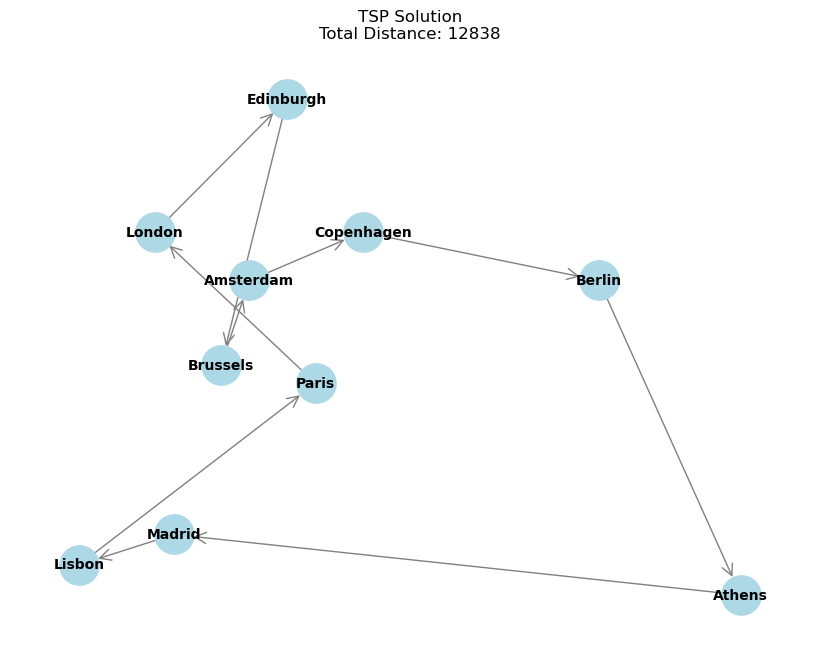

In [29]:
#Now we can re-run the experiment from above, this time using tournament selection:

#Define the hyperparameters,
#following the recommendations presented in the textbook
#Eiben, A.E., Smith, J.E., Introduction to Evolutionary Computing., Springer, 2015, 2nd edition, page 100

#Define population size
n_population = 100 # maximum population size = 100

#Define mutation rate
p_mutation = 0.10 # feel free to adjust

#Crossover probability
p_crossover = 0.6 # feel free to adjust

#Number of iterations
n_iter = 1000 # maximum amount of iterations is 1000

#Set the seed for reproducibility

np.random.seed(5)

#Tournament size
k = 3 # feel free to adjust

#City list, see the index from above
# 0: Amsterdam, 1: Athens, 2: Berlin, 3: Brussels,
#4: Copenhagen, 5: Edinburgh, 6: Lisbon, 7: London, 8: Madrid, 9: Paris



# Adjacency mat
adjacency_mat = np.asarray(
    #Remember that we use the encoding above, i.e. 1 refers to Amsterdam and 10 to Paris!
    [
        [0, 3082, 649, 209, 904, 1180, 2300, 494, 1782, 515], # Distance Amsterdam to the other cities
        [3082, 0, 2552, 3021, 3414, 3768, 4578, 3099, 3940, 3140], # Distance Athens to the other cities
        [649, 2552, 0, 782, 743, 1727, 3165, 1059, 2527, 1094], # Distance Berlin to the other cities
        [209, 3021, 782, 0, 1035, 996, 2080, 328, 1562, 294], # Distance Brussels to the other cities
        [904, 3414, 743, 1035, 0, 1864, 3115, 1196, 2597, 1329], # Distance Copenhagen to the other cities
        [1180, 3768, 1727, 996, 1864, 0, 2879, 656, 2372, 1082], # Distance Edinburgh to the other cities
        [2300, 4578, 3165, 2080, 3115, 2879, 0, 2210, 638, 1786], # Distance Lisbon to the other cities
        [494, 3099, 1059, 328, 1196, 656, 2210, 0, 1704, 414], # Distance London to the other cities
        [1782, 3940, 2527, 1562, 2597, 2372, 638, 1704, 0, 1268], # Distance Madrid to the other cities
        [515, 3140, 1094, 294, 1329, 1082, 1786, 414, 1268, 0] # Distance Paris to the other cities
    ]

)

#Initialize the number of children
number_of_children = 2 # feel free to adjust

number_of_parents = int(n_population / number_of_children)


#Initiliaze the generation
generation = initialize_population(n_population)

#Compute the current best fitness
best_fit_old, best_ind_old = fittest_solution_TSP(compute_distance, generation, adjacency_mat)
print('The current best solution in the initial generation is {0} km and the route is {1}'.format(best_ind_old, best_fit_old))


assert (n_population <= 100), 'population size is greater then 100'
assert (n_iter <= 1000), 'number of iterations is greater then 1000'

for i in range(1, n_iter+1):

    #Initialize the list of new generation
    new_generation = []

    #We loop over the number of parent pairs we need to get
    for j in range(int(number_of_parents)):

        mating_pool = []
        for child in range(number_of_children):


            mate = tournament_selection(generation, compute_distance, adjacency_mat, k)
            mating_pool.append(mate)

        #Cross-over
        child_1, child_2 = crossover(generation[mating_pool[0]], generation[mating_pool[1]],
                                                      p_crossover)

        #Mutation
        child_1 = mutation(child_1, p_mutation)
        child_2 = mutation(child_2, p_mutation)

        #Survival selection is here generational, hence all children replace their parents
        new_generation.append(child_1)
        new_generation.append(child_2)

    generation = new_generation
    #Calculate the best solution and replace the current_best

    best_fit_new, best_ind_new = fittest_solution_TSP(compute_distance, generation, adjacency_mat)

    if best_fit_new < best_fit_old:
        best_fit_old = best_fit_new
        best_ind_old = best_ind_new

    if i % 25 == 0:
        print('The current best population in generation {0} is {1} km and the route is {2}'.format(i, best_ind_old, best_fit_old))

print('\n-----Final tour:----\n')
#Print out the result:
Decoding = {0: 'Ams',
                1: 'Athens',
                2: 'Berlin',
                3: 'Brussels',
                4: 'Copenhagen',
                5: 'Edinburg',
                6: 'Lisbon',
                7: 'London',
                8: 'Madrid',
                9: 'Paris'}


for city in best_ind_old:
    if city == 0:
        print(f'You should start/end in {Decoding[0]}')
    else:
        print(f'Then you should go to {Decoding[city]}')
visualize(best_ind_old)

Goal:

You have run a correct EA if you are able to get the fitness function below 13.500 km traveled.

Try to see if your algorithm is able to find such a solution after the amount of generations that is given.